In [1]:
import cv2
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torch import nn
import torch
from torchvision import transforms
import os
from IPython.display import clear_output
import torch.nn.functional as F
import torchvision.transforms.functional as tf
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
from torchinfo import summary
import segmentation_models_pytorch as smp
import numpy as np

In [2]:
class Roads(Dataset):
    def __init__(self, images_path: str, gt_path: str):
        self.images_path = images_path
        self.gt_path = gt_path
        self.images_path_list = sorted(os.listdir(images_path))
        self.gt_path_list = sorted(os.listdir(gt_path))

    def transform_train(self, image, mask):
        #to tensor
        image =  tf.to_tensor(image)
        mask = tf.to_tensor(mask)

        #random horizontal flip
        if random.random() < 0.5:
            image = tf.hflip(image)
            mask = tf.hflip(mask)

        return image, mask

    def transform_test(self, image, mask):
        #to tensor
        image =  tf.to_tensor(image)
        mask = tf.to_tensor(mask)

        return image, mask

    def __getitem__(self, index):
        image = cv2.imread(self.images_path + "/" + self.images_path_list[index])
        mask = cv2.imread(self.gt_path + "/" + self.gt_path_list[index])

        if 'train' in self.images_path:
            image, mask = self.transform_train(image, mask)
        else:
            image, mask = self.transform_test(image, mask)

        return image, mask[0].unsqueeze(0)

    def __len__(self):
        return len(self.images_path_list)

In [3]:
roads = Roads("data/train/images", "data/train/gt")

In [4]:
def data_representation(data, nums):
    fig, axs = plt.subplots(2, nums, figsize=(10, 5))
    axs[0, 0].set_ylabel("Image")
    axs[1, 0].set_ylabel("Target")
    for i, img in enumerate(random.choices(data, k = nums)):
            image = img[0].permute(1, 2, 0).numpy()
            axs.ravel()[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axs.ravel()[i+nums].imshow(img[1][0], cmap='binary')

            axs.ravel()[i+nums].tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
            axs.ravel()[i].tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
    plt.tight_layout()

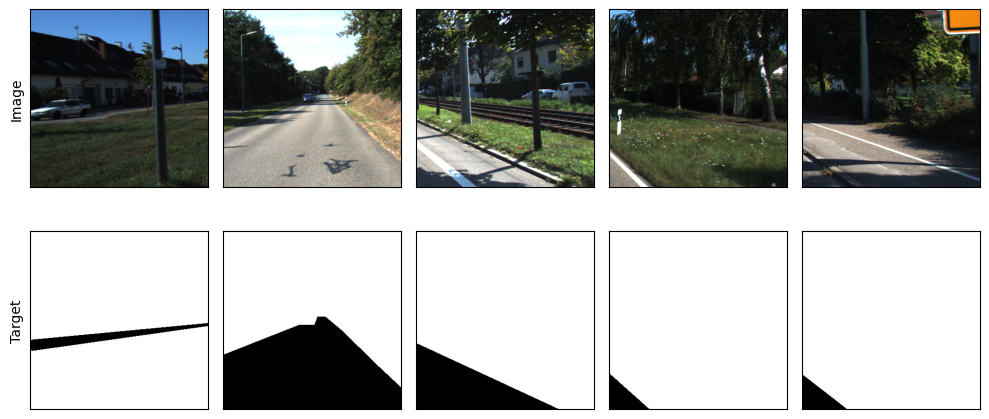

In [5]:
data_representation(roads, 5)

In [6]:
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [7]:
train_image_path = "data/train/images"
train_target_path = "data/train/gt"

test_image_path = "data/test/images"
test_target_path = "data/test/gt"
dataset_train = Roads(train_image_path, train_target_path)
dataset_test = Roads(test_image_path, test_target_path)
batch_size = 16
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [8]:
from torch.cuda.amp import GradScaler
scaler = GradScaler()

In [9]:
class UnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, ksize = 3):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, ksize, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, ksize, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.conv_block(x)

In [10]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            UnetBlock(in_channels, out_channels)
        )
    def forward(self, x):
        return self.down(x)

In [11]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_trans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.up = UnetBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.conv_trans(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat((x1, x2), dim=1)

        return self.up(x)

In [12]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()

        self.init_block =  UnetBlock(3, 64, ksize = 7)
        self.down1 = UnetDown(64, 128)
        self.down2 = UnetDown(128, 256)
        self.down3 = UnetDown(256, 512)
        self.down4 = UnetDown(512, 1024)

        self.up1 = UnetUp(1024, 512)
        self.up2 = UnetUp(512, 256)
        self.up3 = UnetUp(256, 128)
        self.up4 = UnetUp(128, 64)

        self.conv = nn.Conv2d(64, 1, 1, padding="same")

    def forward(self, x):

        x1 = self.init_block(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        x = self.conv(x)
        x = torch.sigmoid(x)

        return x

In [13]:
unet = Unet().to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr= 1e-4, weight_decay=1e-5)
loss_history_train = []
loss_history_test = []
iou_history_train = []
iou_history_test = []

In [14]:
def dice_loss(predicted, target, eps = 1e-6):
    inter = 2 * (predicted * target).sum()
    sets_sum = predicted.sum() + target.sum()
    dice = (inter + eps) / (sets_sum + eps)

    return 1 - dice

In [15]:
def binary_cross_entropy(predicted, target, eps=1e-6, reduction = 'mean'):
    predictions = torch.clamp(predicted, eps, 1 - eps)
    loss = -(target * torch.log(predictions + eps) + (1 - target) * torch.log(1 - predictions + eps))

    if reduction == 'mean':
        loss = loss.mean()
    if reduction == 'sum':
        loss = loss.sum()

    return loss

In [16]:
def focal_loss(predicted, target, alpha = 0.25, gamma = 5, reduction = 'mean'):
    ce_loss = binary_cross_entropy(predicted, target, reduction = 'None')
    p_t = predicted * target + (1 - predicted) * (1 - target)
    loss = ce_loss * ((1 - p_t) ** gamma)
    if alpha >= 0:
        alpha_t = alpha * target + (1 - alpha) * (1 - target)
        loss = alpha_t * loss

    if reduction == 'mean':
         loss = loss.mean()
    if reduction == 'sum':
         loss = loss.sum()
    return loss

In [17]:
def combined_loss(predicted, target, eps=1e-6, bce_weight=0.5, alpha=0.25, gamma=2, reduction='mean'):
    bce = focal_loss(predicted, target)
    dice = dice_loss(predicted, target, eps)
    combined_loss = bce_weight * bce + (1 - bce_weight) * dice
    return combined_loss

In [18]:
def IoU(pred, target, treshold = 0.5, eps=1e-6):
    dim = (-1, -2)
    pred = (pred >= treshold).int()
    intersection = torch.logical_and(pred, target).sum(dim)
    union = torch.logical_or(pred, target).sum(dim)
    iou = (intersection + eps) / (union + eps)
    return iou.mean()

In [19]:
def fit(model, optimizer, dataloader):
  total_loss = 0
  total_iou = 0
  model.train(True)
  for batch in tqdm(dataloader):
    x, y = batch[0], batch[1]
    with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
        pred = model(x.to(device))
        loss = combined_loss(pred, y.to(device))
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad()
    total_loss += loss.item()
    total_iou += IoU(pred, y.to(device)).item()

  return total_loss / len(dataloader), total_iou / len(dataloader)

In [20]:
def eval(model, dataloader):
  total_loss = 0
  total_iou = 0
  model.eval()
  with torch.no_grad():
    for batch in tqdm(dataloader):
      x, y = batch[0], batch[1]
      with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
        pred = model(x.to(device))
        loss = combined_loss(pred, y.to(device))
      total_loss += loss.item()
      total_iou += IoU(pred, y.to(device)).item()

  return total_loss / len(dataloader), total_iou / len(dataloader)

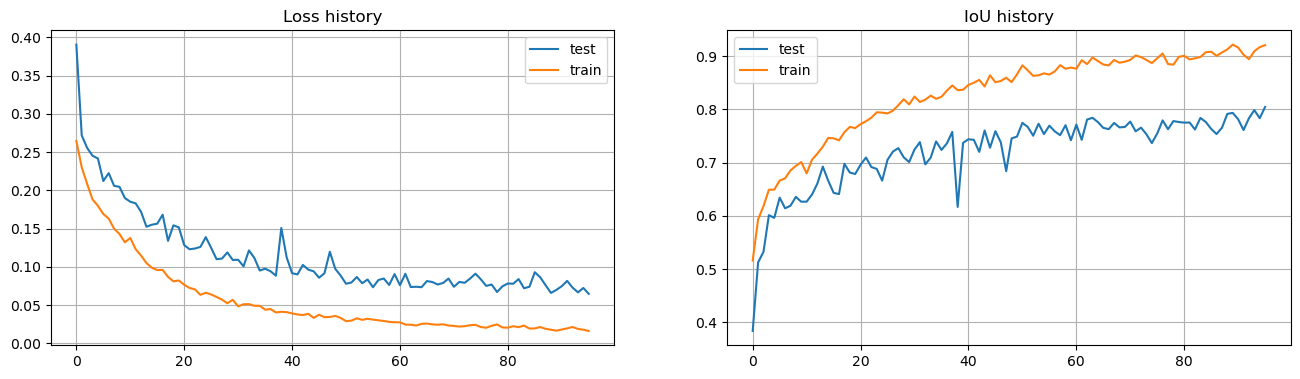

CPU times: total: 3h 30min 6s
Wall time: 39min 38s


In [21]:
%%time
for epoch in range(200):
    train_loss, train_iou = fit(unet, optimizer, train_dataloader)
    test_loss, test_iou = eval(unet, test_dataloader)

    loss_history_train.append(train_loss)
    loss_history_test.append(test_loss)
    iou_history_train.append(train_iou)
    iou_history_test.append(test_iou)

    clear_output(True)
    plt.figure(figsize=[16, 9])
    plt.subplot(2, 2, 1)
    plt.title("Loss history")
    plt.plot(range(epoch+1), loss_history_test, label = "test")
    plt.plot(range(epoch+1), loss_history_train, label = "train")
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.title("IoU history")
    plt.plot(range(epoch+1), iou_history_test, label = "test")
    plt.plot(range(epoch+1), iou_history_train, label = "train")
    plt.legend()
    plt.grid()
    plt.show()

    if test_iou >= 0.8:
        break

In [23]:
print(f"Final Test IoU: {round(iou_history_test[-1], 3)}")

Final Test IoU: 0.804


In [24]:
torch.save(unet.state_dict(), 'unet_weights.pth')

In [25]:
roads = Roads("data/test/images", "data/test/gt")

In [26]:
import random
def show_images_model(data, nums):
    fig, axs = plt.subplots(3, nums, figsize=(15, 8))
    axs[0,0].set_ylabel('Image')
    axs[1,0].set_ylabel('Target')
    axs[2,0].set_ylabel('Predicted')
    for i, img in enumerate(random.choices(data, k = nums)):
            image = img[0].permute(1, 2, 0).numpy()
            axs.ravel()[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            axs.ravel()[i+nums].imshow(img[1][0], cmap = "binary")
            unet_input = img[0][None, ...]
            res = unet(unet_input.to(device))
            loss = combined_loss(res[0][0], img[1][0].to(device))
            res = (res >= 0.5).int()
            axs.ravel()[i+2*nums].imshow(res.cpu().data[0][0], cmap = "binary")
            axs.ravel()[i+2*nums].set_title(f"IoU={round(IoU(res, img[1][0].to(device)).item(), 2)}, loss={round(loss.item(), 3)}")

            axs.ravel()[i+nums].tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
            axs.ravel()[i].tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
            axs.ravel()[i+2*nums].tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
    plt.tight_layout()

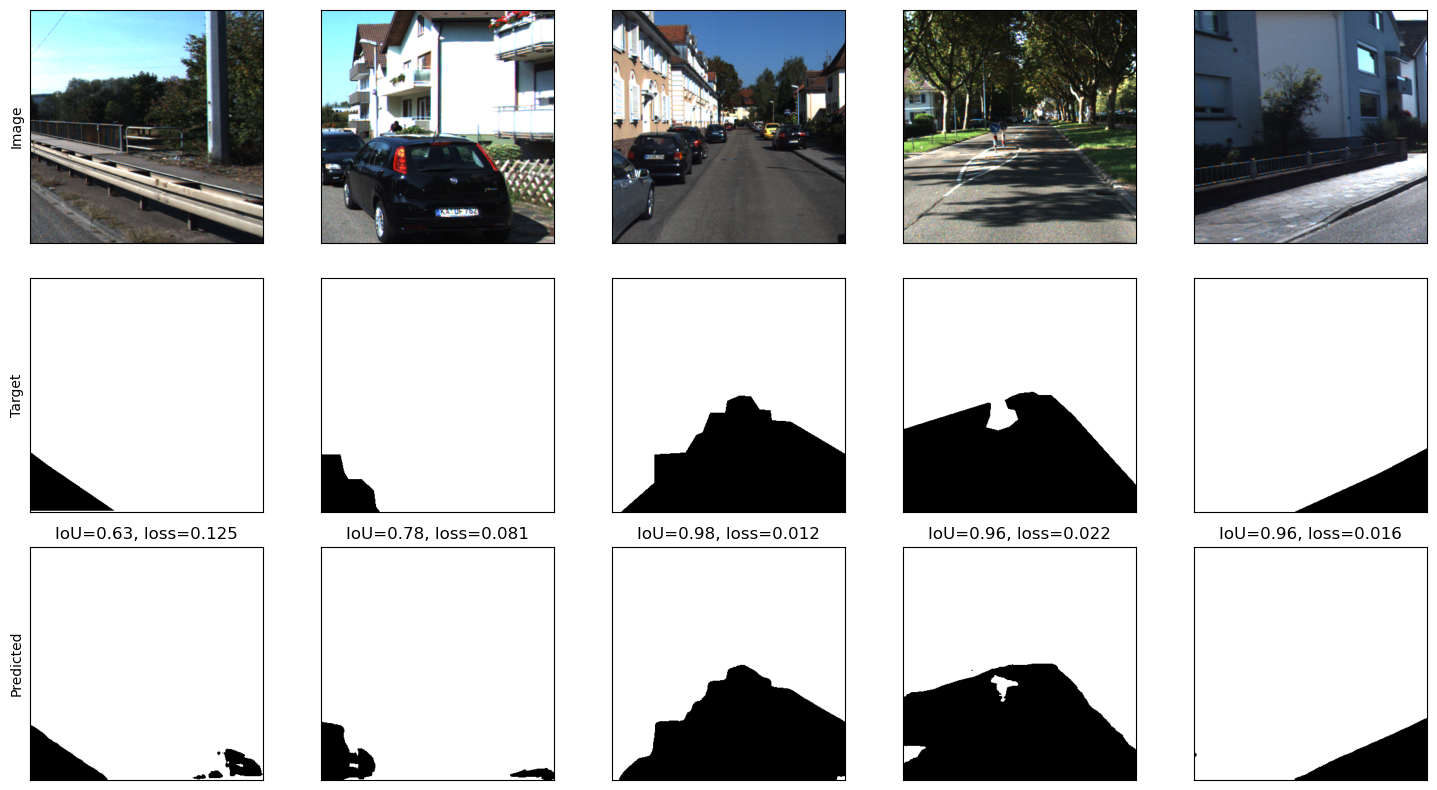

In [28]:
show_images_model(roads, 5)